In [ ]:
!pip install wordcloud
!pip install -U spacy
!pip install keras
!pip install tensorflow
!python -m spacy download en_core_web_sm


import  numpy as np
import  pandas as pd
import seaborn as sb
import time
import os
sb.set() # set the default Seaborn style for graphics
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,recall_score, f1_score, confusion_matrix, precision_score, classification_report
from scipy.sparse import hstack,csr_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,Input
from sklearn import preprocessing
from tensorflow.keras.models import Model
import scipy.sparse as sp
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.model_selection import learning_curve,cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler


In [2]:
# Import the dataset
jobdata = pd.read_csv('fake_job_postings.csv')
jobdata.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [3]:
print("Data type : ", type(jobdata))
print("Data dims : ", jobdata.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (17880, 18)


In [4]:
print(jobdata.dtypes)

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object


In [5]:
jobdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

# Exploratory Data Analysis (EDA)

In [6]:
# Create new variable 'country' in jobdata dataset by cutting out whatever comes after first comma

jobdata['country'] = jobdata['location'].str.split(',').str[0]
jobdata.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent country  
0           0      US  
1           0      NZ  
2           0      US  
3           0      US  
4           0      US

In [7]:
jobdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [8]:
jobdata.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11965
benefits                6203
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
country                   90
dtype: int64

After analysing and understanding all the variables from the dataset, these are the conclusion that we have drawn regarding the datatypes of each variable that needs to be changed:


#### Boolean
- telecommuting
- has_company_logo
- has_question
- fraudulent


#### Categorical
- location
- department
- employment_type
- required_experience
- required_education
- industry
- function
- country

In [9]:
# Change column B and C's values to integers
jobdata = jobdata.astype({'telecommuting': bool,
                          'has_company_logo': bool,
                          'has_questions': bool,
                          'fraudulent': bool,
                          'location': 'category',
                          'department': 'category',
                          'employment_type': 'category',
                          'required_experience': 'category',
                          'required_education': 'category',
                          'industry': 'category',
                          'function': 'category',
                          'country': 'category'})

In [10]:
jobdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   job_id               17880 non-null  int64   
 1   title                17880 non-null  object  
 2   location             17534 non-null  category
 3   department           6333 non-null   category
 4   salary_range         2868 non-null   object  
 5   company_profile      14572 non-null  object  
 6   description          17879 non-null  object  
 7   requirements         15184 non-null  object  
 8   benefits             10668 non-null  object  
 9   telecommuting        17880 non-null  bool    
 10  has_company_logo     17880 non-null  bool    
 11  has_questions        17880 non-null  bool    
 12  employment_type      14409 non-null  category
 13  required_experience  10830 non-null  category
 14  required_education   9775 non-null   category
 15  industry           

In [11]:
jobdata.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
country                  346
dtype: int64

Next, we felt that there are a few variables that could be dropped: (reasons provided)

- **job_id:** Removed because it is merely a label
- **department:** Many missing data, hence not a reliable variable to use to train model (64.58% missing data)
- **salary_range:** Many missing data, hence not a reliable variable to use to train model (83.96% missing data)
- **benefits:** Many missing data, hence not a reliable variable to use to train model (40.34% missing data). In addition, we felt that it would not be too useful of a variable to use.

In [12]:
jobdata = jobdata.drop(['job_id', 'department', 'salary_range', 'benefits'], axis=1)
jobdata.head()

title            location  \
0                           Marketing Intern    US, NY, New York   
1  Customer Service - Cloud Video Production      NZ, , Auckland   
2    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3          Account Executive - Washington DC  US, DC, Washington   
4                        Bill Review Manager  US, FL, Fort Worth   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  telecommuting  \
0  Experience with content management systems a m...          False   
1  What we expect from you:Your key responsibilit...          False   
2  Implement pre-commissioning and commissioning ...          False   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...          False   
4  QUALIFICATIONS:RN license in the State of Texa...          False   

   has_company_logo  has_questions employment_type required_experience  \
0              True          False           Other          Internship   
1              True          False       Full-time      Not Applicable   
2              True          False             NaN                 NaN   
3              True          False       Full-time    Mid-Senior level   
4              True           True       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent country  
0       False      US  
1       False      NZ  
2       False      US  
3       False      US  
4       False      US

In [13]:
jobdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                17880 non-null  object  
 1   location             17534 non-null  category
 2   company_profile      14572 non-null  object  
 3   description          17879 non-null  object  
 4   requirements         15184 non-null  object  
 5   telecommuting        17880 non-null  bool    
 6   has_company_logo     17880 non-null  bool    
 7   has_questions        17880 non-null  bool    
 8   employment_type      14409 non-null  category
 9   required_experience  10830 non-null  category
 10  required_education   9775 non-null   category
 11  industry             12977 non-null  category
 12  function             11425 non-null  category
 13  fraudulent           17880 non-null  bool    
 14  country              17534 non-null  category
dtypes: bool(4), categor

### Fraudulent Count

fraudulent
False    17014
True       866
Name: count, dtype: int64

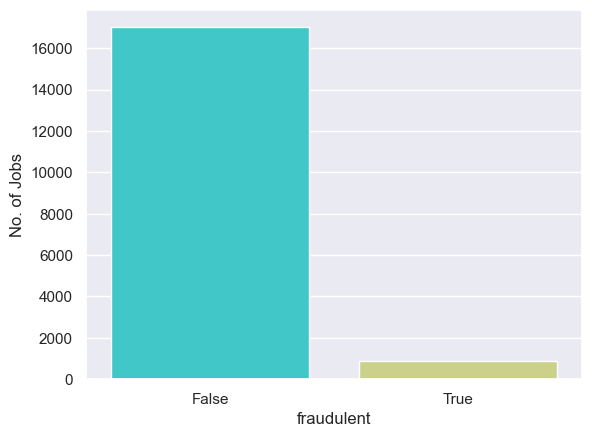

In [14]:
ax = sb.countplot(data=jobdata, x='fraudulent', palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.fraudulent.value_counts()

This shows us that in the dataset, how many jobs are fraudulent as compared to jobs that are not fraudulent.

- **Not fraudulent:** 17014
- **Fraudulent:** 866

### Finding Correlation Between Boolean Data

In [15]:
booldata = pd.DataFrame(jobdata[['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']])
booldata.head()

telecommuting  has_company_logo  has_questions  fraudulent
0          False              True          False       False
1          False              True          False       False
2          False              True          False       False
3          False              True          False       False
4          False              True           True       False

In [16]:
# Correlation Matrix
booldata.corr()

telecommuting  has_company_logo  has_questions  fraudulent
telecommuting          1.000000         -0.019836       0.020345    0.034523
has_company_logo      -0.019836          1.000000       0.233932   -0.261971
has_questions          0.020345          0.233932       1.000000   -0.091627
fraudulent             0.034523         -0.261971      -0.091627    1.000000

<Axes: >

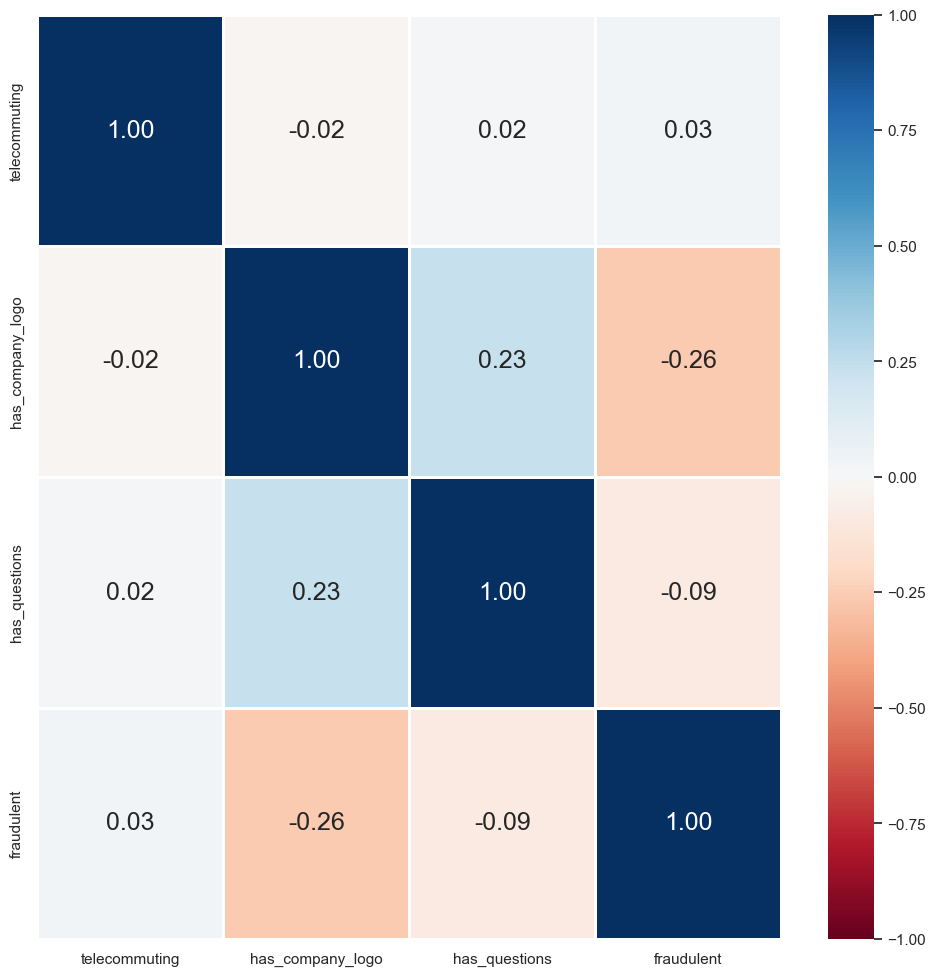

In [17]:
# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(12, 12))
sb.heatmap(booldata.corr(), vmin = -1, vmax = 1, linewidths = 1, annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

We could not draw much conclusion from comparing the correlation between the boolean data in the dataset.
Next, we decided to assess the relationship of each variable with 'fraudulent'. This is to find out how each individual variable influence the likelihood of a job posting being fraudulent.

### **telecommuting   VS   fraudulent**

telecommuting
False    17113
True       767
Name: count, dtype: int64

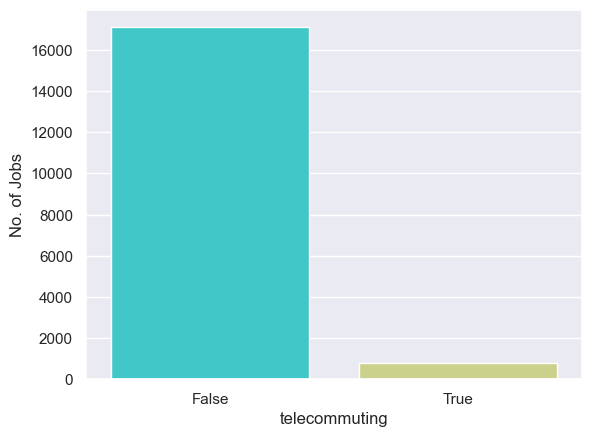

In [20]:
ax = sb.countplot(data=jobdata, x='telecommuting', palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.telecommuting.value_counts()

This shows us that in the dataset, how many jobs allow for telecommuting as compared to jobs that do not allow for telecommuting.

- **Do Not Allow:** 17113
- **Allow:** 767

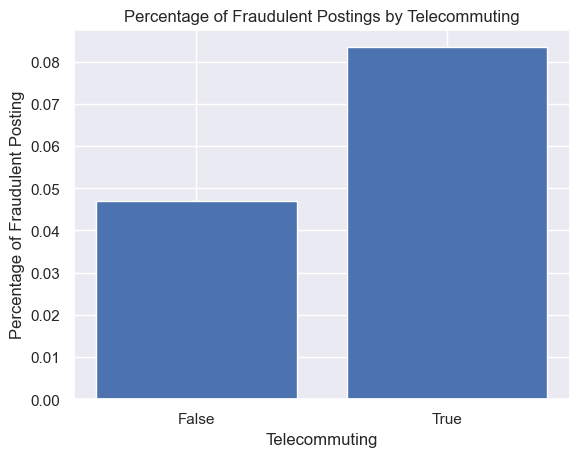

In [21]:
# New dataframe that only consists of 'telecommuting' and 'fraudulent'
teleNfraud = pd.DataFrame(jobdata[['telecommuting', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
teleNfraud = teleNfraud.astype({'fraudulent': int})

Fraud_Telecommuting = teleNfraud.groupby('telecommuting').mean()['fraudulent']
plt.title('Percentage of Fraudulent Postings by Telecommuting')
plt.xlabel('Telecommuting')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(Fraud_Telecommuting.index,dtype='str'),Fraud_Telecommuting)
plt.show()

From here, we can see that despite having a much higher number of job posting that **do not** allow for telecommuting, there is a higher percentage of job postings that is fraudulent, whenever it allows for telecommuting.

Therefore, from this we can see that jobs postings that allow for telecommuting are almost twice as likely to be fraudulent.

### **has_company_logo   VS   fraudulent**

has_company_logo
True     14220
False     3660
Name: count, dtype: int64

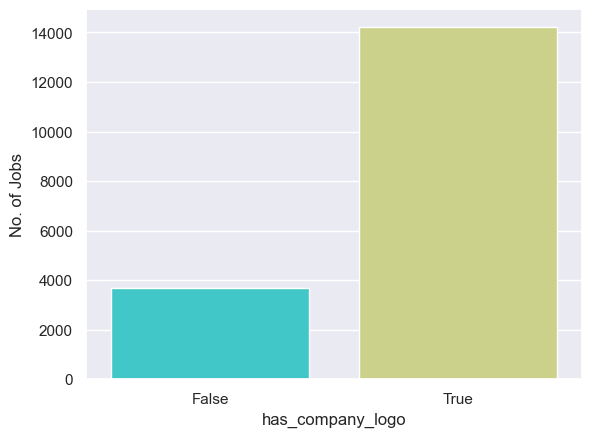

In [22]:
ax = sb.countplot(data=jobdata, x='has_company_logo', palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.has_company_logo.value_counts()

This shows us that in the dataset, how many jobs postings has company logo as compared to job postings without company logo.

- **Logo:** 14220
- **No Logo:** 3660

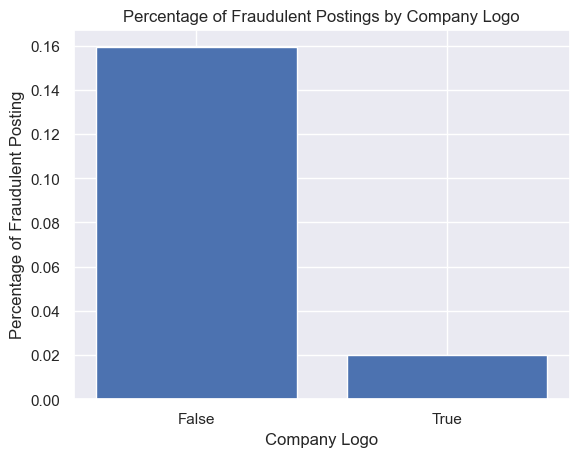

In [23]:
# New dataframe that only consists of 'has_company_logo' and 'fraudulent'
logoNfraud = pd.DataFrame(jobdata[['has_company_logo', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
logoNfraud = logoNfraud.astype({'fraudulent': int})


Fraud_Logo = logoNfraud.groupby('has_company_logo').mean()['fraudulent']
plt.title('Percentage of Fraudulent Postings by Company Logo')
plt.xlabel('Company Logo')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(Fraud_Logo.index,dtype='str'), Fraud_Logo)
plt.show()

From here, we can see that there is a higher percentage of job postings that is fraudulent, whenever it **has no company logo**.

Therefore, from this we can see that jobs postings that have no company logo accounts for **16% of being fraudulent**, which **has higher likelihood** than jobs postings with company logo to be fraudulent.

### **has_questions   VS   fraudulent**

has_questions
False    9088
True     8792
Name: count, dtype: int64

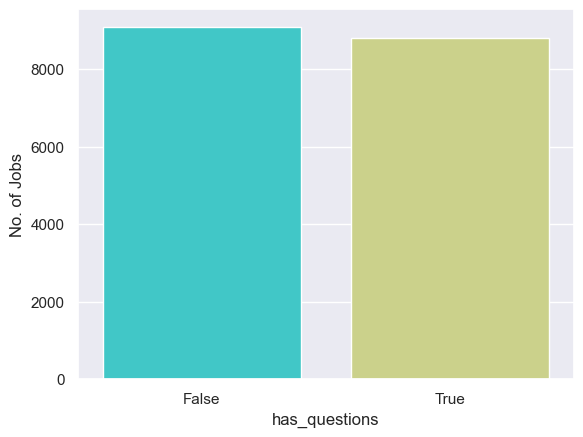

In [24]:
ax = sb.countplot(data=jobdata, x='has_questions', palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.has_questions.value_counts()

This shows us that in the dataset, how many jobs postings has questions as compared to job postings without questions.

- **Has questions** 8792
- **Has no questions** 9088

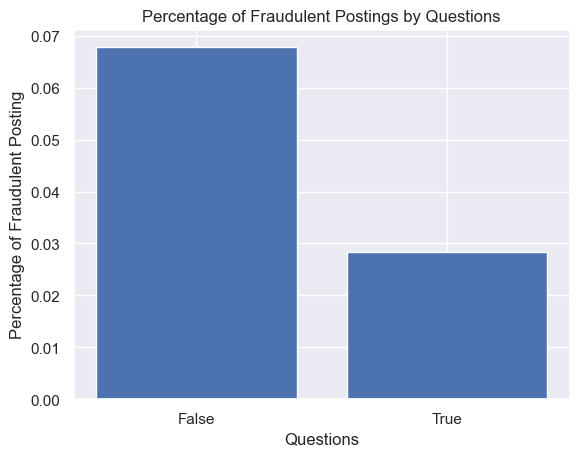

In [25]:
# New dataframe that only consists of 'has_questions' and 'fraudulent'
questionNfraud = pd.DataFrame(jobdata[['has_questions', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
questionNfraud = questionNfraud.astype({'fraudulent': int})


Fraud_Question = questionNfraud.groupby('has_questions').mean()['fraudulent']
plt.title('Percentage of Fraudulent Postings by Questions')
plt.xlabel('Questions')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(Fraud_Question.index,dtype='str'), Fraud_Question)
plt.show()

From here, we can see that there is a higher percentage of job postings that is fraudulent **which is 7%**, whenever it **has no questions**.

Therefore, from this we can see that jobs postings **without questions has higher likelihood** than jobs postings that have questions to be fraudulent.

### employment_type   VS   fraudulent

employment_type
Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64

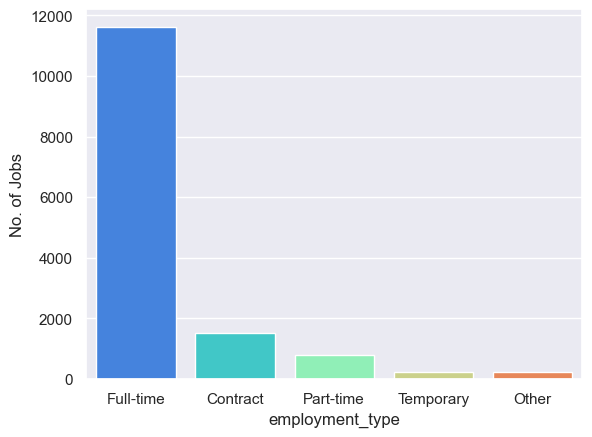

In [26]:
employment_type = jobdata['employment_type'].value_counts().index.tolist()
ax = sb.countplot(data=jobdata, x='employment_type', order=employment_type, palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.employment_type.value_counts()

This shows how many of each employment type are there in the dataset:

- **Full-time:** 11620
- **Contract:** 1524
- **Part-time:** 797
- **Temporary:** 241
- **Other:** 227

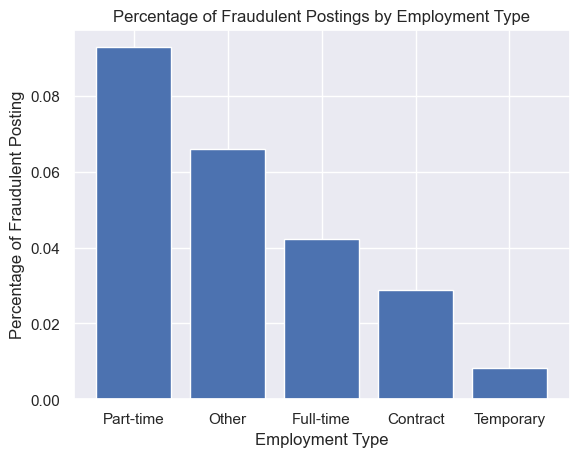

In [27]:
# New dataframe that only consists of 'employment_type' and 'fraudulent'
employtypeNfraud = pd.DataFrame(jobdata[['employment_type', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
employtypeNfraud = employtypeNfraud.astype({'fraudulent': int})

Fraud_Employtype = employtypeNfraud.groupby('employment_type').mean()['fraudulent']

# Sort in descending order
Fraud_Employtype_sorted = Fraud_Employtype.sort_values(ascending=False)

plt.title('Percentage of Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(Fraud_Employtype_sorted.index,dtype='str'), Fraud_Employtype_sorted)
plt.show()

From this, we can see that **part-time job postings** has the highest chance of being a fraudulent job posting.

### required_experience   VS   fraudulent

required_experience
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: count, dtype: int64

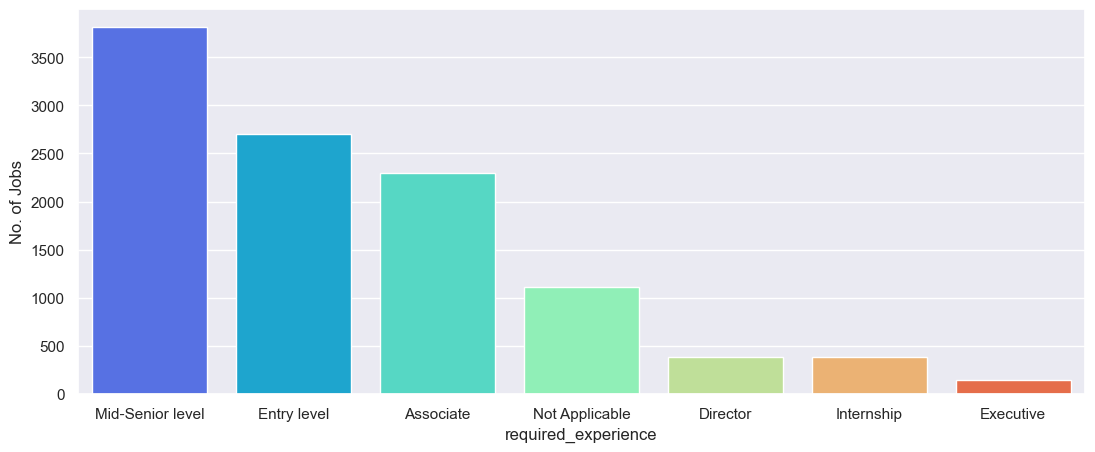

In [28]:
plt.figure(figsize=(13,5))

required_experience = jobdata['required_experience'].value_counts().index.tolist()
ax = sb.countplot(data=jobdata, x='required_experience', order=required_experience, palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.required_experience.value_counts()

This shows how many of each required experience are there in the dataset:



• **Mid-Senior level**  :3809

• **Entry level**     :2697

• **Associate**       :2297

• **Not Applicable**  :1116

• **Director**       :389

• **Internship**      :381

• **Executive**       :141






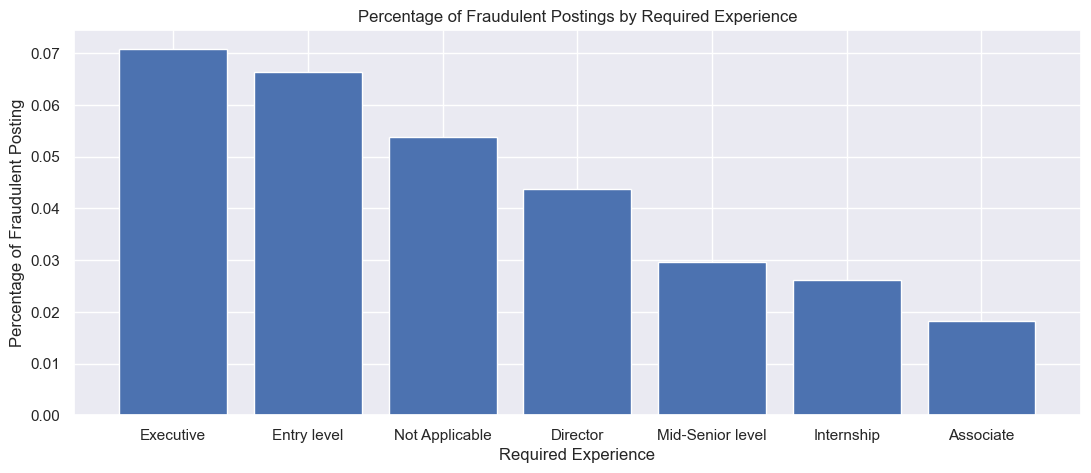

In [29]:
# New dataframe that only consists of 'required_experience' and 'fraudulent'
reqexpNfraud = pd.DataFrame(jobdata[['required_experience', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
reqexpNfraud = reqexpNfraud.astype({'fraudulent': int})


Fraud_ReqExp = reqexpNfraud.groupby('required_experience').mean()['fraudulent']

# Sort in descending order
Fraud_ReqExp_sorted = Fraud_ReqExp.sort_values(ascending=False)

plt.figure(figsize=(13,5))
plt.title('Percentage of Fraudulent Postings by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(Fraud_ReqExp_sorted.index,dtype='str'), Fraud_ReqExp_sorted)
plt.show()

From here, we can see that **executive jobs postings has the highest likelihood** of being a fraudulent job posting, followed by **entry level job postings.**

### required_education   VS   fraudulent

required_education
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: count, dtype: int64

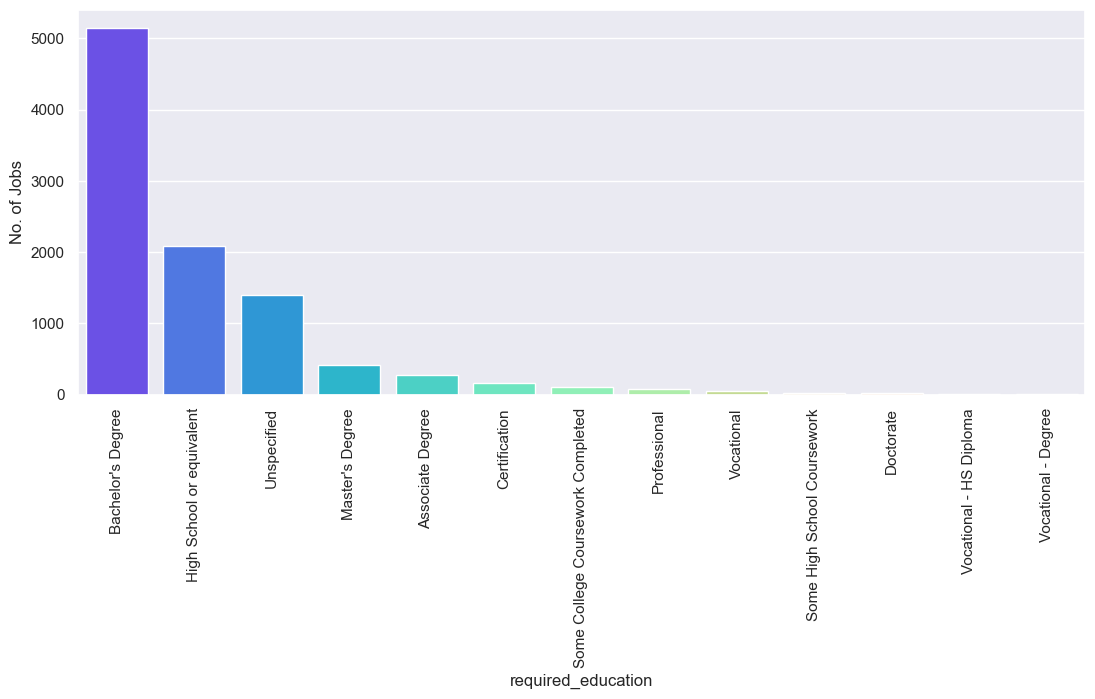

In [30]:
plt.figure(figsize=(13,5))
plt.xticks(rotation=90)

required_education = jobdata['required_education'].value_counts().index.tolist()
ax = sb.countplot(data=jobdata, x='required_education', order=required_education, palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.required_education.value_counts()

This shows how many of each required education are there in the dataset:

• **Bachelor's Degree**                    5145

• **High School or equivalent**            2080

• **Unspecified**                          1397

• **Master's Degree**                       416

• **Associate Degree**                      274

• **Certification**                         170

• **Some College Coursework Completed**     102

• **Professional**                           74

• **Vocational**                             49

• **Some High School Coursework**            27

• **Doctorate**                              26

• **Vocational - HS Diploma**                 9

• **Vocational - Degree**                     6

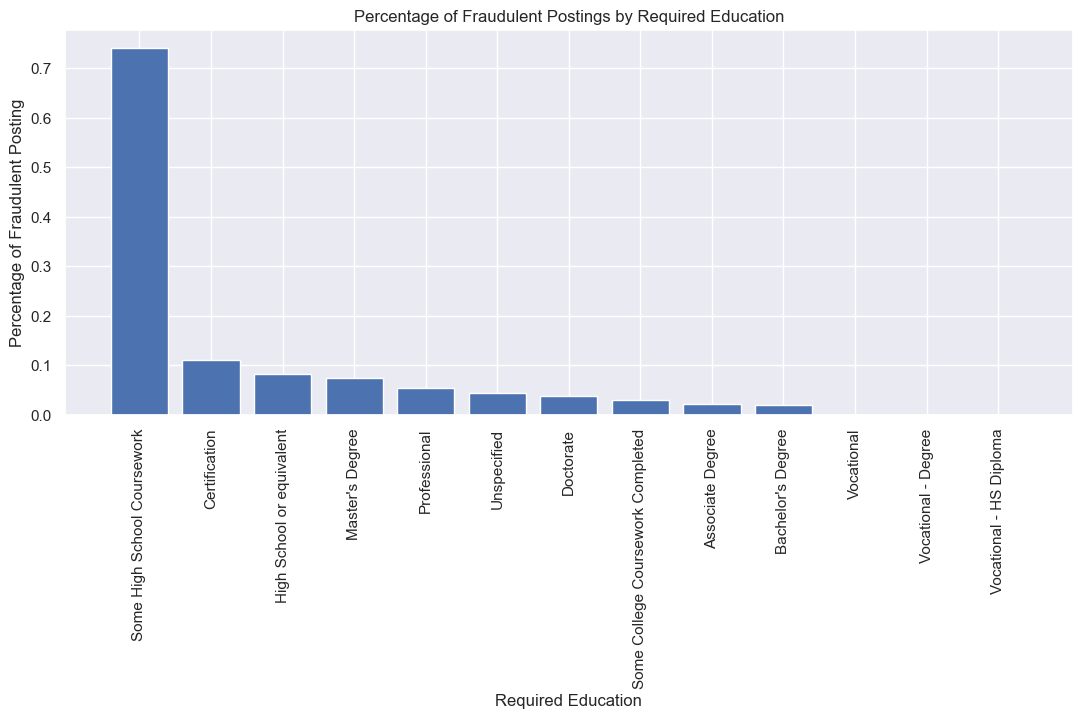

In [31]:
# New dataframe that only consists of 'required_education' and 'fraudulent'
reqeduNfraud = pd.DataFrame(jobdata[['required_education', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
reqeduNfraud = reqeduNfraud.astype({'fraudulent': int})


Fraud_ReqEdu = reqeduNfraud.groupby('required_education').mean()['fraudulent']

# Sort in descending order
Fraud_ReqEdu_sorted = Fraud_ReqEdu.sort_values(ascending=False)

plt.figure(figsize=(13,5))
plt.xticks(rotation=90)
plt.title('Percentage of Fraudulent Postings by Required Education')
plt.xlabel('Required Education')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(Fraud_ReqEdu_sorted.index,dtype='str'), Fraud_ReqEdu_sorted)
plt.show()

From this, we can see that majority of the job postings that are fraudulent only require for the applicant to have some high school coursework as their required education, as compared to needing some kind of certification or any higher education.

### industry   VS   fraudulent

industry
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
                                       ... 
Shipbuilding                              1
Alternative Dispute Resolution            1
Ranching                                  1
Wine and Spirits                          1
Sporting Goods                            1
Name: count, Length: 131, dtype: int64

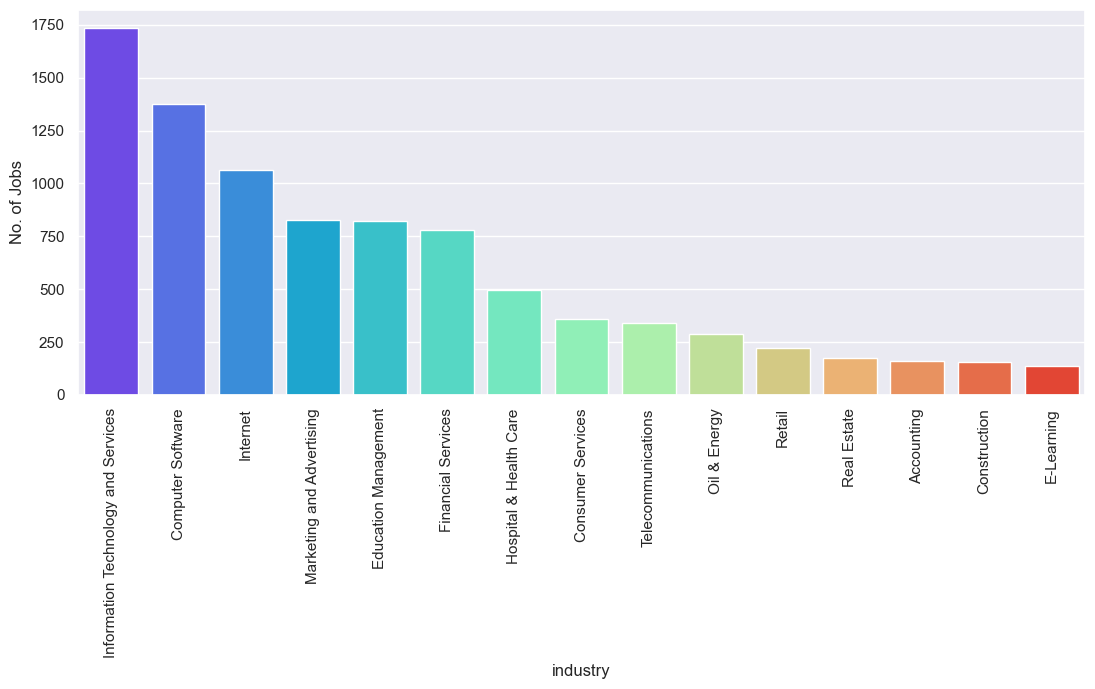

In [32]:
plt.figure(figsize=(13,5))
plt.xticks(rotation=90)

industry = jobdata['industry'].value_counts().nlargest(15).index.tolist()
ax = sb.countplot(data=jobdata, x='industry', order=industry, palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.industry.value_counts()

This shows how many of each main industry are there in the dataset:

• **Information Technology and Services**    1734

• **Computer Software**                      1376

• **Internet**                               1062

• **Marketing and Advertising**               828

• **Education Management**                    822

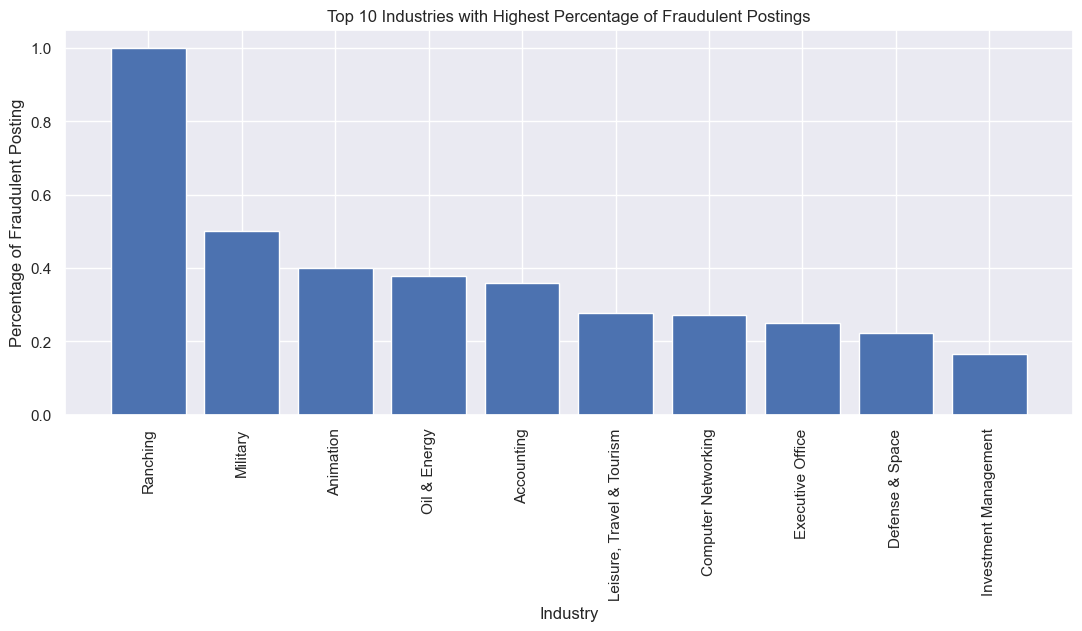

In [33]:
# New dataframe that only consists of 'industry' and 'fraudulent'
industryNfraud = pd.DataFrame(jobdata[['industry', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
industryNfraud = industryNfraud.astype({'fraudulent': int})


Fraud_Industry = industryNfraud.groupby('industry').mean()['fraudulent']

# Sort in descending order
Fraud_Industry_sorted = Fraud_Industry.sort_values(ascending=False)

# Showing top 10 results
top_10 = Fraud_Industry_sorted.head(10)


plt.figure(figsize=(13,5))
plt.xticks(rotation=90)
plt.title('Top 10 Industries with Highest Percentage of Fraudulent Postings')
plt.xlabel('Industry')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(top_10.index, dtype='str'), top_10)
plt.show()

From this, we can see that job postings in the industry of **ranching** **are 100% fraudulent**, followed by **50% **of job postings in the **military** industry which are fraudulent.

### function   VS   fraudulent

function
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Art/Creative               132
Writing/Editing            132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    38

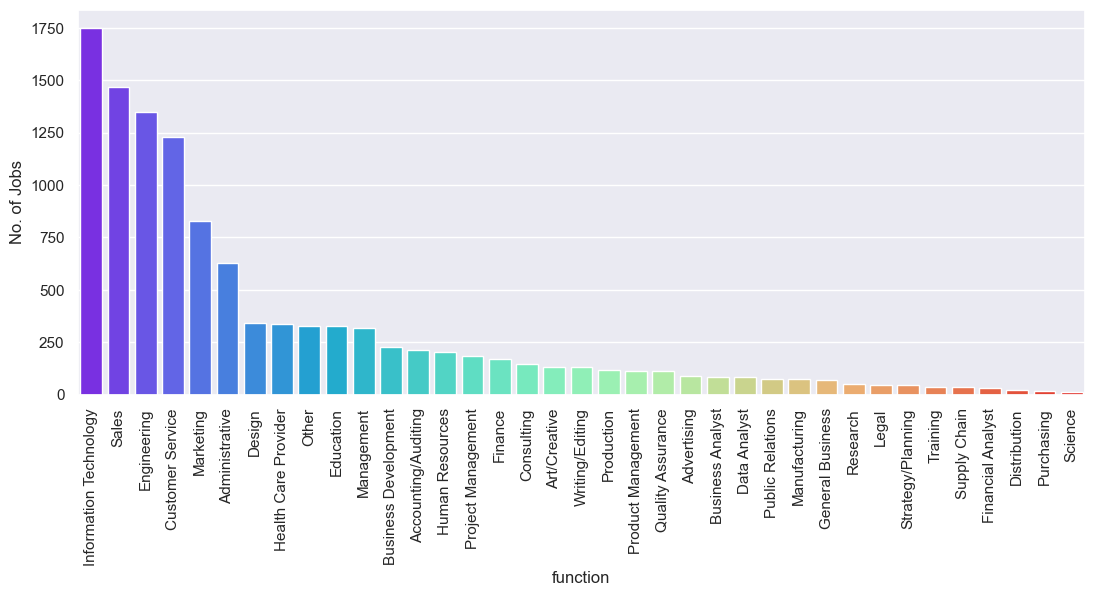

In [34]:
plt.figure(figsize=(13,5))
plt.xticks(rotation=90)

function = jobdata['function'].value_counts().index.tolist()
ax = sb.countplot(data=jobdata, x='function', order=function, palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.function.value_counts()

This shows how many of each function are there in the dataset

• **Information Technology**    1749

• **Sales**                     1468

• **Engineering**               1348

• **Customer Service**          1229

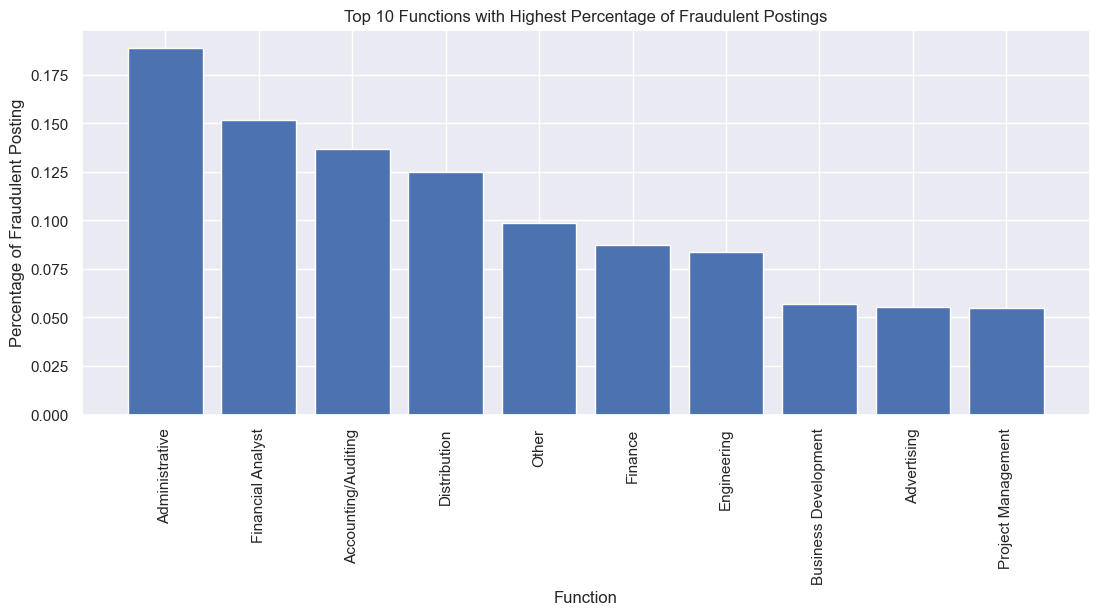

In [35]:
# New dataframe that only consists of 'function' and 'fraudulent'
funcNfraud = pd.DataFrame(jobdata[['function', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
funcNfraud = funcNfraud.astype({'fraudulent': int})


Fraud_Func = funcNfraud.groupby('function').mean()['fraudulent']

# Sort in descending order
Fraud_Func_sorted = Fraud_Func.sort_values(ascending=False)

# Showing top 10 results
top_10 = Fraud_Func_sorted.head(10)


plt.figure(figsize=(13,5))
plt.xticks(rotation=90)
plt.title('Top 10 Functions with Highest Percentage of Fraudulent Postings')
plt.xlabel('Function')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(top_10.index, dtype='str'), top_10)
plt.show()

This shows that **administrative job postings** account for **17%** to be fraudulent. It has highest chance of being fraudulent compared to other functions.

### country   VS   fraudulent

country
US    10656
GB     2384
GR      940
CA      457
DE      383
      ...  
UG        1
CM        1
KZ        1
SD        1
PE        1
Name: count, Length: 90, dtype: int64

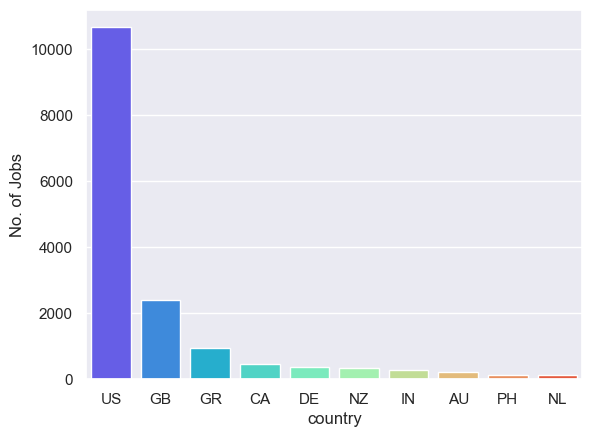

In [36]:
country = jobdata['country'].value_counts().nlargest(10).index.tolist()
ax = sb.countplot(data=jobdata, x='country', order=country, palette='rainbow')
ax.set_ylabel('No. of Jobs')
jobdata.country.value_counts()

This shows how many of each main country are there in the dataset

• **US**    :10656

• **GB**     :2384

• **GR**      :940

• **CA**     :457

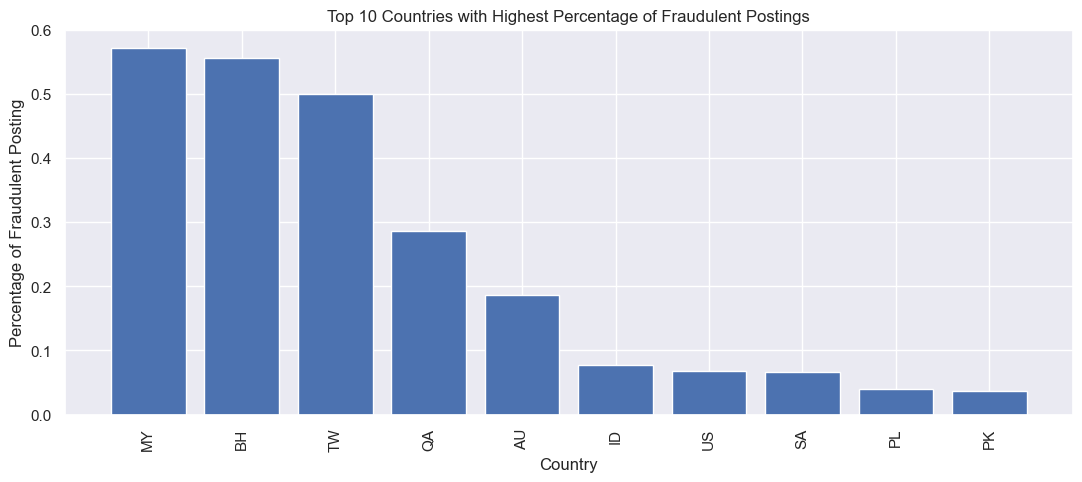

In [37]:
# New dataframe that only consists of 'country' and 'fraudulent'
countryNfraud = pd.DataFrame(jobdata[['country', 'fraudulent']])

# As we will need the variable 'fraudulent' in its mean form, we convert it back to numeric temporarily in this new dataframe
countryNfraud = countryNfraud.astype({'fraudulent': int})


Fraud_Country = countryNfraud.groupby('country').mean()['fraudulent']

# Sort in descending order
Fraud_Country_sorted = Fraud_Country.sort_values(ascending=False)

# Showing top 10 results
top_10 = Fraud_Country_sorted.head(10)


plt.figure(figsize=(13,5))
plt.xticks(rotation=90)
plt.title('Top 10 Countries with Highest Percentage of Fraudulent Postings')
plt.xlabel('Country')
plt.ylabel('Percentage of Fraudulent Posting')
plt.bar(np.array(top_10.index, dtype='str'), top_10)
plt.show()

From this, we can see that **Malaysia** has the highest number of fraudulent job postings among all countries.

## Conclusion on Boolean & Categorical variables

**Useful:**
- telecommuting
- has_company_logo
- has_questions
- employment_type
- required_education
- country


**Not useful:**
- required_experience
- Industry
- Function

## Analysis on Textual Data

In [38]:
# Create new dataframe with all the text combined into one column and add the fraudulent column
text_data = pd.DataFrame()
text_data['text'] = jobdata['title'] + ' ' + jobdata['company_profile'] + ' ' + jobdata['description'] + ' ' + jobdata['requirements']
text_data = text_data.join(jobdata['fraudulent'])

#Removing NaN values
text_data.fillna(' ', inplace=True)

text_data.head()

text  fraudulent
0  Marketing Intern We're Food52, and we've creat...       False
1  Customer Service - Cloud Video Production 90 S...       False
2  Commissioning Machinery Assistant (CMA) Valor ...       False
3  Account Executive - Washington DC Our passion ...       False
4  Bill Review Manager SpotSource Solutions LLC i...       False

In [39]:
#Seperate fraud and real job postings
fraud = text_data[text_data.fraudulent==True].text
real = text_data[text_data.fraudulent==False].text

In [40]:
Stopwords = spacy.lang.en.stop_words.STOP_WORDS

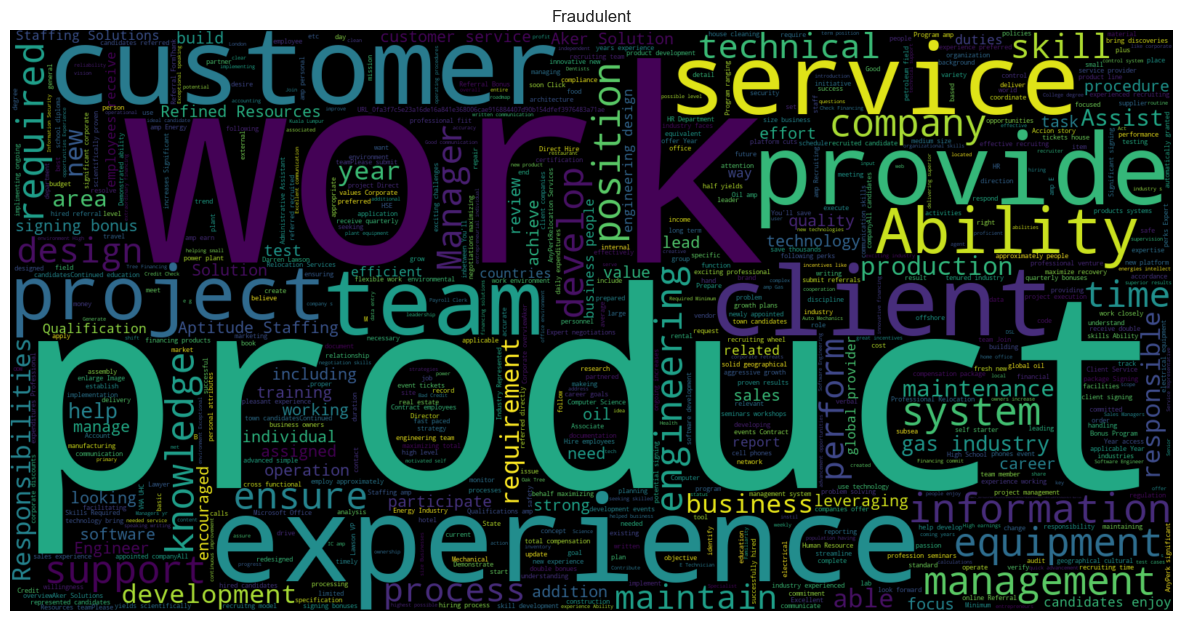

In [41]:
# Generate Word cloud for fraud job posting texts
plt.figure(figsize = (15,15))
word_cloud = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = Stopwords).generate(str(" ".join(fraud)))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Fraudulent')
plt.show()

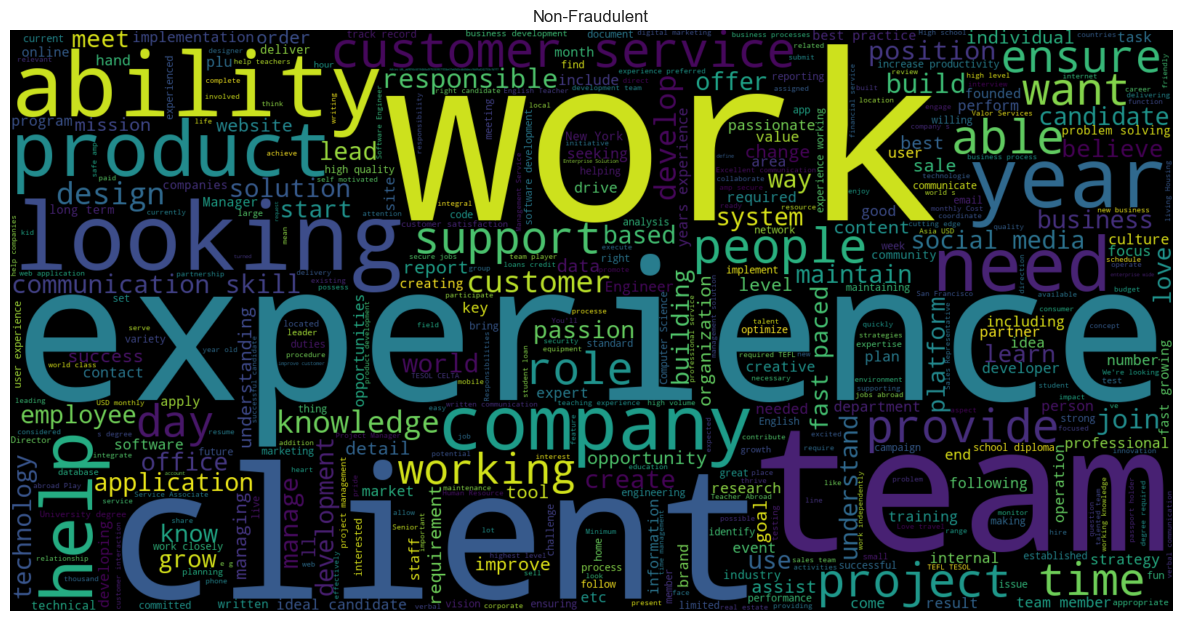

In [42]:
# Generate Word cloud for real job posting texts
plt.figure(figsize = (15,15))
word_cloud = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = Stopwords).generate(str(" ".join(real)))
plt.imshow(word_cloud,interpolation = 'bilinear')
plt.axis("off")
plt.title('Non-Fraudulent')
plt.show()

From this, we can conclude that **"product", "service" and "customer"** are likely to appear in non-fraudulent job posting texts.

**"Client","team","looking"** are likely to appear in fraudulent job postings texts.

**"Work" and "experience"** are commonly used in job postings texts.


# Machine Learning Models using Textual Data

## Textual Data Cleaning

In [43]:
# Define function used to clean text data

def clean_text(text):

    text = text.lower()                                              # converts entire text to lowercase
    text = re.sub(r'<.*?>', '', text)                                # remove HTML tags from the text
    text = re.sub(r'http\S+', '', text)                              # remove URLs from the text
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)                        # replace any character not a letter or a digit with space
    tokens = nltk.word_tokenize(text)                                # tokenizes the cleaned text into individual words
    stop_words = set(nltk.corpus.stopwords.words('english'))         # retrieves a set of English stopwords from the NLTK library
    tokens = [word for word in tokens if word not in stop_words]     # removes stopwords from the tokenized text
    cleaned_text = ' '.join(tokens)                                  # joins the filtered tokens back into a single string, separated by spaces

    return cleaned_text                                              # returns the cleaned text

In [44]:
text_data['text'] = text_data['text'].apply(clean_text)
text_data.head()

text  fraudulent
0  marketing intern food52 created groundbreaking...       False
1  customer service cloud video production 90 sec...       False
2  commissioning machinery assistant cma valor se...       False
3  account executive washington dc passion improv...       False
4  bill review manager spotsource solutions llc g...       False

In [45]:
# Define function used to normalized text

nlp = spacy.load("en_core_web_sm")

def normalize_text(text):
    # Tokenize the text and apply lemmatization
    doc = nlp(text)
    normalized_words = [token.lemma_ for token in doc]
    normalized_text = ' '.join(normalized_words)

    return normalized_text

In [46]:
text_data['text'] = text_data['text'].apply(normalize_text)
text_data.head()

text  fraudulent
0  marketing intern food52 create groundbreaking ...       False
1  customer service cloud video production 90 sec...       False
2  commission machinery assistant cma valor servi...       False
3  account executive washington dc passion improv...       False
4  bill review manager spotsource solution llc gl...       False

In [47]:
# Apply Part-of-Speech tagging

text_data['pos_features'] = text_data['text'].apply(lambda x: nltk.pos_tag(word_tokenize(x[0])) if len(x) > 0 else [])
text_data['pos_features'] = text_data['pos_features'].apply(lambda tags: ' '.join(tag[1] for tag in tags))
text_data.head()

text  fraudulent pos_features
0  marketing intern food52 create groundbreaking ...       False           NN
1  customer service cloud video production 90 sec...       False          NNS
2  commission machinery assistant cma valor servi...       False          NNS
3  account executive washington dc passion improv...       False           DT
4  bill review manager spotsource solution llc gl...       False           NN

Part-of-Speech (POS) tagging is the process of assigning grammatical categories (such as noun, verb, adjective, etc.) to words in a sentence based on their context and definition. In natural language processing (NLP), POS tagging is an essential task that helps in understanding the syntactic structure and meaning of text.

In [48]:
predictors = text_data.drop('fraudulent', axis=1)
predictors.head()

text pos_features
0  marketing intern food52 create groundbreaking ...           NN
1  customer service cloud video production 90 sec...          NNS
2  commission machinery assistant cma valor servi...          NNS
3  account executive washington dc passion improv...           DT
4  bill review manager spotsource solution llc gl...           NN

In [49]:
# Apply CountVectorizer on predictor variables

vectorizer = CountVectorizer(ngram_range=(1, 2))
text_matrix = vectorizer.fit_transform(predictors['text'])
pos_matrix = vectorizer.transform(predictors['pos_features'])
X = hstack([text_matrix, pos_matrix])                                # X is the predictor variables

with open('countvectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [50]:
y = pd.DataFrame(text_data['fraudulent'])                            # y is the response varaible 'fraudulent'

## Textual Models

In [51]:
# Split into Train and Test (Random train-test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Logistic Regression

C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Cross-validation scores: [0.96271439 0.96569724 0.96681581 0.96644295 0.96457867]
Average cross-validation score: 0.9652498135719612
Test set accuracy: 0.962192393736018
Test set precision: 1.0
Test set recall: 0.27155172413793105
Test set F1 score: 0.42711864406779665


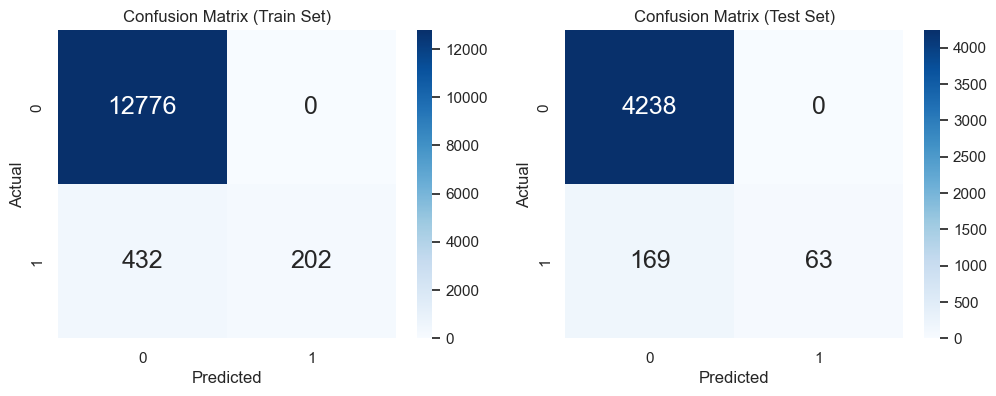

In [52]:
model1 = LogisticRegression(max_iter=500)

model1.fit(X_train, y_train)

y_train_pred1 = model1.predict(X_train)
y_test_pred1 = model1.predict(X_test)

cv_scores = cross_val_score(model1, X_train, y_train, cv=5)
accuracy = accuracy_score(y_test, y_test_pred1)
precision = precision_score(y_test, y_test_pred1)
recall = recall_score(y_test, y_test_pred1)
f1 = f1_score(y_test, y_test_pred1)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred1),
           annot = True, cmap='Blues', fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sb.heatmap(confusion_matrix(y_test, y_test_pred1),
           annot = True, cmap='Blues', fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())
print('Test set accuracy:', accuracy)
print('Test set precision:', precision)
print('Test set recall:', recall)
print('Test set F1 score:', f1)


The confusion matrix for the Logistic Regression model indicates that it performs well overall, with a high average cross-validation score of approximately 0.965. However, when looking at the test set performance, the accuracy is slightly lower at 0.962, suggesting that the model may not generalize as well to unseen data. The precision for the test set is 1.0, indicating that when the model predicts a job listing as fraudulent, it is almost always correct. However, the recall is relatively low at 0.272, suggesting that the model misses a significant number of actual fraudulent listings. This trade-off between precision and recall is reflected in the F1 score of 0.427, which considers both metrics and indicates a balance between them. Overall, while the model performs well in terms of precision, it may benefit from improvements in recall to better identify fraudulent job postings.

### MultinomialNB

C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Cross-validation scores: [0.9541387  0.95525727 0.95339299 0.9541387  0.95451156]
Average cross-validation score: 0.9542878448918717
Test set accuracy: 0.9512304250559284
Test set precision: 0.7333333333333333
Test set recall: 0.09482758620689655
Test set F1 score: 0.16793893129770993


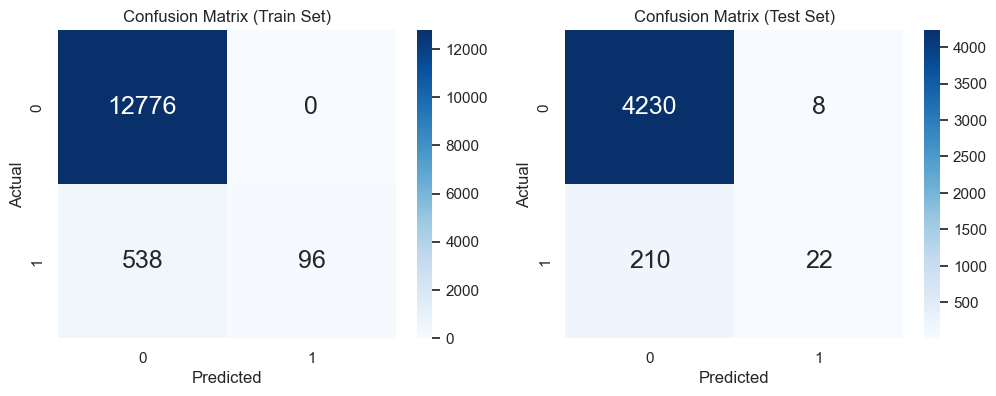

In [53]:
model2 = MultinomialNB()

model2.fit(X_train, y_train)

y_train_pred2 = model2.predict(X_train)
y_test_pred2 = model2.predict(X_test)

cv_scores = cross_val_score(model2, X_train, y_train, cv=5)
accuracy = accuracy_score(y_test, y_test_pred2)
precision = precision_score(y_test, y_test_pred2)
recall = recall_score(y_test, y_test_pred2)
f1 = f1_score(y_test, y_test_pred2)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred2),
           annot = True, cmap='Blues', fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sb.heatmap(confusion_matrix(y_test, y_test_pred2),
           annot = True, cmap='Blues', fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())
print('Test set accuracy:', accuracy)
print('Test set precision:', precision)
print('Test set recall:', recall)
print('Test set F1 score:', f1)


The Multinomial Naive Bayes model achieved a high average cross-validation score of approximately 0.9543, indicating its effectiveness in classifying fraudulent job postings. However, when evaluated on the test set, the model's accuracy was slightly lower at 0.9512. This suggests that the model's performance may vary slightly when applied to unseen data.

The precision of the model on the test set was 0.7333, indicating that when it predicted a job posting as fraudulent, it was correct approximately 73.33% of the time. The recall, or sensitivity, of the model was low at 0.0948, indicating that the model only identified 9.48% of all fraudulent job postings in the test set. This low recall suggests that the model may have difficulty identifying all instances of fraudulent job postings.

The F1 score, which is the harmonic mean of precision and recall, was 0.1679. This indicates a trade-off between precision and recall, as the F1 score balances these two metrics. Overall, while the Multinomial Naive Bayes model performed well in terms of accuracy and cross-validation scores, its performance in terms of precision, recall, and F1 score suggests that it may benefit from further tuning or the use of additional features to improve its ability to identify fraudulent job postings.

### SVC

C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wayle\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Cross-validation scores: [0.95824012 0.96047726 0.9601044  0.95861298 0.95973154]
Average cross-validation score: 0.9594332587621178
Test set accuracy: 0.9579418344519016
Test set precision: 1.0
Test set recall: 0.1896551724137931
Test set F1 score: 0.3188405797101449


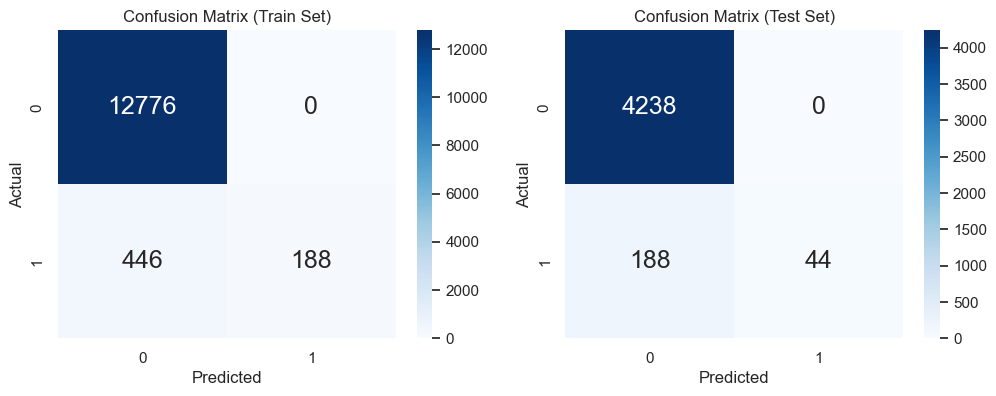

In [54]:
model3 = SVC()

model3.fit(X_train, y_train)

y_train_pred3 = model3.predict(X_train)
y_test_pred3 = model3.predict(X_test)

cv_scores = cross_val_score(model3, X_train, y_train, cv=5)
accuracy = accuracy_score(y_test, y_test_pred3)
precision = precision_score(y_test, y_test_pred3)
recall = recall_score(y_test, y_test_pred3)
f1 = f1_score(y_test, y_test_pred3)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred3),
           annot = True, cmap='Blues', fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sb.heatmap(confusion_matrix(y_test, y_test_pred3),
           annot = True, cmap='Blues', fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())
print('Test set accuracy:', accuracy)
print('Test set precision:', precision)
print('Test set recall:', recall)
print('Test set F1 score:', f1)


The confusion matrix analysis for Support Vector Classification (SVC) with the provided cross-validation scores and test set metrics shows a high average cross-validation score of approximately 0.9594, indicating that the model performs well across different subsets of the data during training. However, the test set accuracy, which measures the overall correctness of predictions, is slightly lower at around 0.9579, indicating a small drop in performance on unseen data.

The precision score of 1.0 indicates that when the model predicts a fraudulent job posting, it is always correct. However, the recall score of 0.1897 suggests that the model has a relatively low ability to correctly identify fraudulent job postings out of all actual fraudulent postings. This indicates a high rate of false negatives, where actual fraudulent postings are incorrectly classified as non-fraudulent.

The F1 score, which considers both precision and recall, is 0.3188. This score balances the trade-off between precision and recall, providing a single metric to evaluate the model's overall performance. The relatively low F1 score suggests that there is room for improvement in the model's ability to balance precision and recall for fraudulent job posting detection.

# Machine learning models using categorical data

#Cleaning for categorical data


There are some missing values in the dataset.

In [55]:
#We use data_Xclean to indicate raw datas(not clean)
data_Xclean = jobdata.copy()
data_Xclean.isnull().sum()


title                     0
location                346
company_profile        3308
description               1
requirements           2696
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
country                 346
dtype: int64

In [56]:
data_Xclean.info()
data_cat = pd.DataFrame(data_Xclean[['country','telecommuting','has_company_logo','has_questions','employment_type','required_education']])
data_cat.info()
#we use data_cat to preserve the categorical datas.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                17880 non-null  object  
 1   location             17534 non-null  category
 2   company_profile      14572 non-null  object  
 3   description          17879 non-null  object  
 4   requirements         15184 non-null  object  
 5   telecommuting        17880 non-null  bool    
 6   has_company_logo     17880 non-null  bool    
 7   has_questions        17880 non-null  bool    
 8   employment_type      14409 non-null  category
 9   required_experience  10830 non-null  category
 10  required_education   9775 non-null   category
 11  industry             12977 non-null  category
 12  function             11425 non-null  category
 13  fraudulent           17880 non-null  bool    
 14  country              17534 non-null  category
dtypes: bool(4), categor

In [57]:
# Convert categorical variables into objects first before able to replace Nan values
data_cat = data_cat.astype({'employment_type': 'object',
                          'required_education': 'object',
                          'country': 'object'})

#Replace NaN values with blank space
data_cat.fillna(' ', inplace=True)


# Convert back to categorical
data_cat = data_cat.astype({'employment_type': 'category',
                          'required_education': 'category',
                          'country': 'category'})

In [58]:
data_cat.head()

country  telecommuting  has_company_logo  has_questions employment_type  \
0      US          False              True          False           Other   
1      NZ          False              True          False       Full-time   
2      US          False              True          False                   
3      US          False              True          False       Full-time   
4      US          False              True           True       Full-time   

  required_education  
0                     
1                     
2                     
3  Bachelor's Degree  
4  Bachelor's Degree

In [59]:
#initialize X as categorical datas
X = pd.get_dummies(data_cat, prefix_sep = '_')
X.head()

telecommuting  has_company_logo  has_questions  country_   country_AE  \
0          False              True          False      False       False   
1          False              True          False      False       False   
2          False              True          False      False       False   
3          False              True          False      False       False   
4          False              True           True      False       False   

   country_AL  country_AM  country_AR  country_AT  country_AU  ...  \
0       False       False       False       False       False  ...   
1       False       False       False       False       False  ...   
2       False       False       False       False       False  ...   
3       False       False       False       False       False  ...   
4       False       False       False       False       False  ...   

   required_education_Doctorate  required_education_High School or equivalent  \
0                         False                                         False   
1                         False                                         False   
2                         False                                         False   
3                         False                                         False   
4                         False                                         False   

   required_education_Master's Degree  required_education_Professional  \
0                               False                            False   
1                               False                            False   
2                               False                            False   
3                               False                            False   
4                               False                            False   

   required_education_Some College Coursework Completed  \
0                                              False      
1                                              False      
2                                              False      
3                                              False      
4                                              False      

   required_education_Some High School Coursework  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   

   required_education_Unspecified  required_education_Vocational  \
0                           False                          False   
1                           False                          False   
2                           False                          False   
3                           False                          False   
4                           False                          False   

   required_education_Vocational - Degree  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   required_education_Vocational - HS Diploma  
0                                       False  
1                                       False  
2                                       False  
3                                       False  
4                                       False  

[5 rows x 114 columns]

In [60]:
#standardize the features in array X
X = StandardScaler().fit_transform(X)

In [61]:
Y = jobdata['fraudulent']
Y = LabelEncoder().fit_transform(Y)
#convert categorical labels in Y to numerical lebels

In [65]:
def forest_test(A, B):
    A_Train, A_Test, B_Train, B_Test = train_test_split(A, B, test_size = 0.30, random_state = 101)
    CPUtime = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=700).fit(A_Train,B_Train)
    print("Total execution time: {}".format(time.process_time() - CPUtime))

    B_train_pred = trainedforest.predict(A_Train)
    B_test_pred = trainedforest.predict(A_Test)
    #print(confusion_matrix(B_Test,predictionforest))
    #print(classification_report(B_Test,predictionforest))
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(B_Train, B_train_pred),
           annot = True, cmap='Blues', fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    axes[0].set_title('Confusion Matrix (Train Set)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sb.heatmap(confusion_matrix(B_Test, B_test_pred),
               annot = True, cmap='Blues', fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
    axes[1].set_title('Confusion Matrix (Test Set)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    print("Test Set Accuracy: {:.2f}%".format(accuracy_score(B_Test, B_test_pred) * 100))


Total execution time: 5.5
Test Set Accuracy: 95.62%


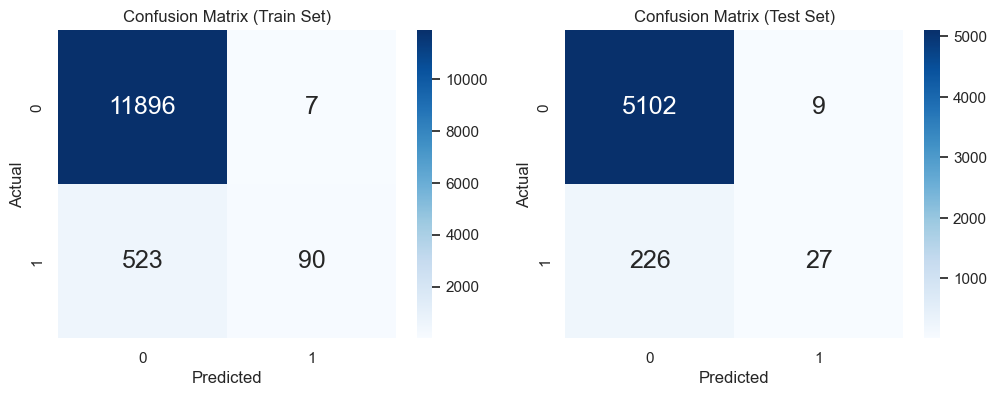

In [66]:
forest_test(X, Y)

A Test accuracy of **95.62%** shows that random forest is a relatively accurate model in predidcting Fraudulent postings.

# Takeaways

**Yee Hong**: I'm in charge of exploring random forest classifier. It helps me understand how to handle non-linear relationships and feature interactions using multiple variables.

**Waylen**: I learnt that if one model fails to capture certain patterns or makes incorrect assumptions, other models can compensate. Execution of multiple models will potentially lead to more accurate predictions overall.

**Wei Zhang**: The most interesting machine learning model I have learnt is Support Vector Classification due to its ability to find the optimal hyperplane that maximizes the margin between different classes in high-dimensional spaces.

# Conclusion

Through the use of Logistic Regression, Multinomial Naive Bayes, Support Vector Classification, and Random Forest models for predicting fraudulent job postings, a key learning outcome is the importance of model selection and understanding their strengths and limitations. Logistic Regression offers simplicity and interpretability, making it suitable for initial exploratory analysis. Multinomial Naive Bayes, despite its assumption of feature independence, can be effective in text classification tasks. Support Vector Classification, while powerful, requires careful tuning and may be computationally intensive. Random Forest excels in handling categorical data and capturing non-linear relationships. By combining these models, one can leverage their individual strengths to improve the overall predictive performance and gain deeper insights into fraudulent job posting detection strategies.